# Traffic Sign Classification with Keras



## Dataset

The network you'll build with Keras is similar to the example in Keras’s GitHub repository that builds out a [convolutional neural network for MNIST](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py). 

However, instead of using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, you're going to use the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset that you've used previously.

You can download pickle files with sanitized traffic sign data here:

In [1]:
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

Training and Test data downloaded.


## Overview

Here are the steps you'll take to build the network:

1. Load the training data.
2. Preprocess the data.
3. Build a feedforward neural network to classify traffic signs.
4. Build a convolutional neural network to classify traffic signs.
5. Evaluate the final neural network on testing data.


In [2]:
import pickle
import numpy as np
import math

## Load the Data

Start by importing the data from the pickle file.

In [4]:
with open('train.p', 'rb') as f:
    data = pickle.load(f)
type(data)

dict

In [5]:
print(data.keys())

dict_keys(['features', 'labels'])


In [8]:
# Load the feature data to the variable X_train
X_train = data['features']
# Load the label data to the variable y_train
y_train = data['labels']

print(X_train.shape)
print(y_train.shape)
print(y_train[-1])
type(X_train)

(39209, 32, 32, 3)
(39209,)
42


numpy.ndarray

## Preprocess the Data

1. Shuffle the data
2. Normalize the features using Min-Max scaling between -0.5 and 0.5
3. One-Hot Encode the labels

### Shuffle the data
Hint: You can use the [scikit-learn shuffle](http://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html) function to shuffle the data.

In [9]:
# Shuffle the data
from sklearn.utils import shuffle                                                                                          
X_train, y_train = shuffle(X_train, y_train)

In [10]:
print(y_train[ 0]) # label for the 1st image
print(y_train[-1])  # label for the last image

5
11


### Normalize the features


In [11]:
X_train.dtype

dtype('uint8')

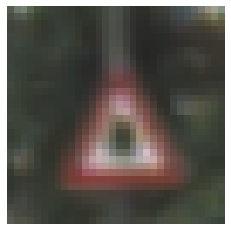

In [12]:
import matplotlib.pyplot as plt
plt.imshow(X_train[-1].astype('uint8'))
plt.axis('off')
plt.show()

In [13]:
X_train[0]

array([[[ 75,  91,  87],
        [ 91, 104, 100],
        [ 85, 102, 101],
        ...,
        [ 89, 102, 103],
        [ 80,  94, 101],
        [ 86,  97,  98]],

       [[ 88, 102,  97],
        [100, 106, 101],
        [ 94, 110, 107],
        ...,
        [ 83,  97,  99],
        [ 82,  95, 101],
        [ 81,  92,  93]],

       [[ 89, 102,  97],
        [ 96, 102,  98],
        [ 92, 106, 104],
        ...,
        [ 83,  94,  96],
        [ 88,  99,  98],
        [ 87,  98, 101]],

       ...,

       [[ 93, 108,  99],
        [ 86, 106,  98],
        [ 83, 100,  94],
        ...,
        [ 67,  81,  83],
        [ 70,  83,  82],
        [ 74,  87,  88]],

       [[ 90, 100,  91],
        [ 86, 104,  94],
        [ 86, 100,  92],
        ...,
        [ 64,  76,  78],
        [ 72,  84,  83],
        [ 77,  90,  90]],

       [[ 69,  80,  76],
        [ 74,  85,  78],
        [ 75,  87,  81],
        ...,
        [ 62,  74,  76],
        [ 65,  78,  78],
        [ 64,  75,  78]]

In [15]:
X_train[0].shape

(32, 32, 3)

In [22]:
# TODO: Normalize the data features to the variable X_normalized
X_min = 0
X_max = 255
X_train = X_train.astype('float32')
X_normalized = X_train/255

In [23]:
first_image = X_train[0].reshape(1,-1)

In [24]:
32*32*3

3072

In [25]:
first_image.shape

(1, 3072)

### One-Hot Encode the labels
Hint: You can use the [scikit-learn LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) function to one-hot encode the labels.

In [16]:
# TODO: One Hot encode the labels to the variable y_one_hot
from sklearn import preprocessing 
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_one_hot =lb.transform(y_train)
# y_one_hot =lb.fit_transform(y_train)

In [17]:
y_one_hot[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Keras Sequential Model
```python
from keras.models import Sequential

# Create the Sequential model
model = Sequential()
```
The `keras.models.Sequential` class is a wrapper for the neural network model. Just like many of the class models in scikit-learn, it provides common functions like `fit()`, `evaluate()`, and `compile()`.  We'll cover these functions as we get to them.  Let's start looking at the layers of the model.

## Keras Layer
A Keras layer is just like a neural network layer.  It can be fully connected, max pool, activation, etc.  You can add a layer to the model using the model's `add()` function.  For example, a simple model would look like this:
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten

# Create the Sequential model
model = Sequential()

# 1st Layer - Add a flatten layer
model.add(Flatten(input_shape=(32, 32, 3)))

# 2nd Layer - Add a fully connected layer
model.add(Dense(100))

# 3rd Layer - Add a ReLU activation layer
model.add(Activation('relu'))

# 4th Layer - Add a fully connected layer
model.add(Dense(60))

# 5th Layer - Add a ReLU activation layer
model.add(Activation('relu'))
```
Keras will automatically infer the shape of all layers after the first layer.  This means you only have to set the input dimensions for the first layer.

The first layer from above, `model.add(Flatten(input_shape=(32, 32, 3)))`, sets the input dimension to (32, 32, 3) and output dimension to (3072=32\*32\*3).  The second layer takes in the output of the first layer and sets the output dimenions to (100).  This chain of passing output to the next layer continues until the last layer, which is the output of the model.

## Build a Multi-Layer Feedforward Network

Build a multi-layer feedforward neural network to classify the traffic sign images.

1. Set the first layer to a `Flatten` layer with the `input_shape` set to (32, 32, 3)
2. Set the second layer to `Dense` layer width to 128 output. 
3. Use a ReLU activation function after the second layer.
4. Set the output layer width to 43, since there are 43 classes in the dataset.
5. Use a softmax activation function after the output layer.

To get started, review the Keras documentation about [models](https://keras.io/models/sequential/) and [layers](https://keras.io/layers/core/).

The Keras example of a [Multi-Layer Perceptron](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py) network is similar to what you need to do here. Use that as a guide, but keep in mind that there are a number of differences.

In [ ]:
32*32*3*128 + 128 + (128*43 + 43)

398891

In [ ]:
32*32*3 >> pixels in each image

SyntaxError: invalid syntax (<ipython-input-18-81d95af0560b>, line 1)

In [23]:
# TODO: Build a Multi-layer feedforward neural network with Keras here.
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten 

model = Sequential()
model.add(Flatten(input_shape = (32,32,3)))  # This is the input layer

model.add(Dense(128,kernel_initializer='lecun_uniform',\
          bias_initializer='zeros', activation='relu'))        # This is the hidden layer with 128 neurons

model.add(Dense(43, activation='softmax'))         # This is the output layer

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_5 (Dense)              (None, 43)                5547      
Total params: 398,891
Trainable params: 398,891
Non-trainable params: 0
_________________________________________________________________


,## Training a Sequential Model
You built a multi-layer neural network in Keras, now let's look at training a neural network.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
...

# Configures the learning process and metrics
model.compile('sgd', 'mean_squared_error', ['accuracy'])

# Train the model
# History is a record of training loss and metrics
history = model.fit(x_train_data, Y_train_data, batch_size=128, nb_epoch=2, validation_split=0.2)

# Calculate test score
test_score = model.evaluate(x_test_data, Y_test_data)
```
The code above configures, trains, and tests the model.  The line `model.compile('sgd', 'mean_squared_error', ['accuracy'])` configures the model's optimizer to `'sgd'`(stochastic gradient descent), the loss to `'mean_squared_error'`, and the metric to `'accuracy'`.  

You can find more optimizers [here](https://keras.io/optimizers/), loss functions [here](https://keras.io/objectives/#available-objectives), and more metrics [here](https://keras.io/metrics/#available-metrics).

To train the model, use the `fit()` function as shown in `model.fit(x_train_data, Y_train_data, batch_size=128, nb_epoch=2, validation_split=0.2)`.  The `validation_split` parameter will split a percentage of the training dataset to be used to validate the model.  The model can be further tested with the test dataset using the `evaluate()` function as shown in the last line.

## Train the Network

1. Compile the network using adam optimizer and categorical_crossentropy loss function.
2. Train the network for ten epochs and validate with 20% of the training data.

In [25]:
# TODO: Compile and train the model here.

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=120, \
                    epochs=10, validation_split= 0.2)

Epoch 1/10
262/262 [==============================] - 4s 17ms/step - loss: 2.4942 - accuracy: 0.4048 - val_loss: 1.7624 - val_accuracy: 0.5843
Epoch 2/10
262/262 [==============================] - 3s 12ms/step - loss: 1.4611 - accuracy: 0.6634 - val_loss: 1.2063 - val_accuracy: 0.7114
Epoch 3/10
262/262 [==============================] - 4s 15ms/step - loss: 1.0445 - accuracy: 0.7628 - val_loss: 0.8703 - val_accuracy: 0.8230
Epoch 4/10
262/262 [==============================] - 3s 12ms/step - loss: 0.8135 - accuracy: 0.8222 - val_loss: 0.7483 - val_accuracy: 0.8284
Epoch 5/10
262/262 [==============================] - 3s 11ms/step - loss: 0.6822 - accuracy: 0.8476 - val_loss: 0.6032 - val_accuracy: 0.8766
Epoch 6/10
262/262 [==============================] - 3s 11ms/step - loss: 0.5777 - accuracy: 0.8744 - val_loss: 0.5597 - val_accuracy: 0.8725
Epoch 7/10
262/262 [==============================] - 3s 10ms/step - loss: 0.5122 - accuracy: 0.8881 - val_loss: 0.5121 - val_accuracy: 0.8806

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

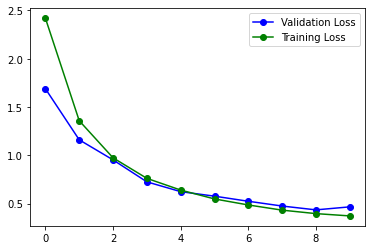

In [36]:
plt.plot(range(0,10), history.history['val_loss'], 'b-o')
plt.plot(range(0,10), history.history['loss'], 'g-o')
plt.legend(['Validation Loss', 'Training Loss'])

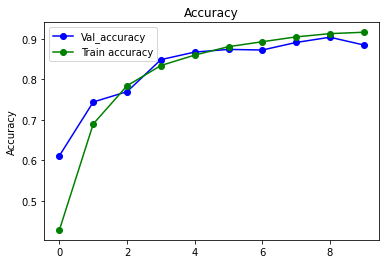

In [37]:
plt.plot(range(0,10), history.history['val_accuracy'], 'b-o')
plt.plot(range(0,10), history.history['accuracy'], 'g-o')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['Val_accuracy','Train accuracy' ])

In [26]:
# TODO: Re-construct the network and add dropout after the pooling layer.
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers import Conv2D, pooling
from keras import models,layers

model = Sequential()
model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), padding='same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Flatten()) 
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2)) 
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(43, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_7 (Dense)              (None, 43)               

In [27]:
# TODO: Compile and train the model
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=120, \
                    epochs=10, validation_split= 0.2)

Epoch 1/10
262/262 [==============================] - 77s 295ms/step - loss: 1.8782 - accuracy: 0.4886 - val_loss: 0.7670 - val_accuracy: 0.7610
Epoch 2/10
262/262 [==============================] - 71s 271ms/step - loss: 0.4375 - accuracy: 0.8767 - val_loss: 0.2806 - val_accuracy: 0.9259
Epoch 3/10
262/262 [==============================] - 71s 273ms/step - loss: 0.2121 - accuracy: 0.9436 - val_loss: 0.2217 - val_accuracy: 0.9364
Epoch 4/10
262/262 [==============================] - 72s 274ms/step - loss: 0.1333 - accuracy: 0.9651 - val_loss: 0.1596 - val_accuracy: 0.9550
Epoch 5/10
262/262 [==============================] - 73s 277ms/step - loss: 0.0925 - accuracy: 0.9750 - val_loss: 0.0976 - val_accuracy: 0.9758
Epoch 6/10
262/262 [==============================] - 85s 324ms/step - loss: 0.0744 - accuracy: 0.9799 - val_loss: 0.0919 - val_accuracy: 0.9760
Epoch 7/10
262/262 [==============================] - 66s 251ms/step - loss: 0.0475 - accuracy: 0.9877 - val_loss: 0.0799 - val_ac

**Best Validation Accuracy:** 98.07%

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

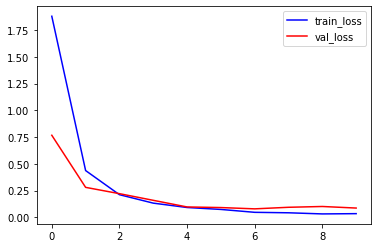

In [29]:
plt.plot(history.history['loss'], 'b-')
plt.plot(history.history['val_loss'], 'r-')
plt.legend(['train_loss','val_loss'])

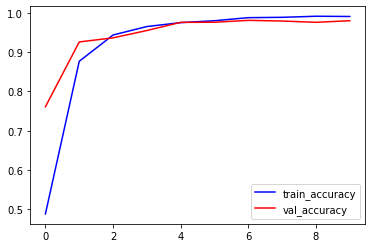

In [30]:
plt.plot(history.epoch, history.history['accuracy'], 'b-')
plt.plot(history.epoch, history.history['val_accuracy'], 'r-')
plt.legend(['train_accuracy','val_accuracy'])


## Testing
Once you've picked out your best model, it's time to test it.

Load up the test data and use the [`evaluate()` method](https://keras.io/models/model/#evaluate) to see how well it does.

Hint 1: The `evaluate()` method should return an array of numbers. Use the [`metrics_names`](https://keras.io/models/model/) property to get the labels.

In [31]:
# TODO: Load test data
with open('test.p', 'rb') as f:
    data = pickle.load(f)
X_test = data['features']
y_test = data['labels']

In [32]:
# TODO: Normalize the data features to the variable X_normalized
X_test = X_test.astype('float32')
X_test_normalized = X_test/255

In [33]:
# TODO: Preprocess data & one-hot encode the labels
y_test_one_hot =lb.transform(y_test)

In [34]:
# TODO: Evaluate model on test data
metrics = model.evaluate(X_test_normalized, y_test_one_hot)

395/395 [==============================] - 8s 21ms/step - loss: 0.5732 - accuracy: 0.9063


In [35]:
metrics

[0.5732498168945312, 0.9063341021537781]

model.summary()